In [1]:
from tg.common.outfittery.delivery import SagemakerLogs
from datetime import datetime

SagemakerLogs.BUCKET = 'ps-data-science-sandbox'
SagemakerLogs.PROJECT_NAME = 'tsa'

The aim is to understand such a high quality with PCLS1 (which is, again, only word-in-question).

Some refactoring was done to introduce allow-lists for features.

Initial run just to see it still works after refactoring the way it did

metric,iteration,loss,roc_auc_score_display,roc_auc_score_test
job_id,,,,
TSA-PCL1-PCLS05-PNS20-2022-05-26-12-52-54-457,14.0,0.087477,0.950786,0.950708


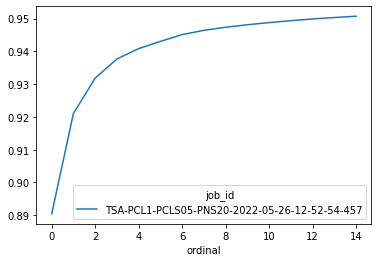

In [2]:
job_ids = ['TSA-PCL1-PCLS05-PNS20-2022-05-26-12-52-54-457'
]

sl = SagemakerLogs(job_ids).load_from_s3()
sl.get_metric_by_job('roc_auc_score_test').plot()

sl.get_last_values().sort_values('roc_auc_score_test',ascending=False)

## Feature Allow lists (-FAL)

Legend:
 * `P` pymorphy
 * `M` slovnet (morphology-only features)
 * `S` syntax (only `relation` feature from slovnet
 * `F` syntax fixes. Slovnet output is not really a tree, in contains cycles and forests. There is a procedure fixing this, and it indicates for the words that they were in the wrong position in a tree. The idea is that incorrect input distorts the `slovnet`, hence knowing where distortions are may help.
 * `T` sTatistics. Amount of descendants, size of subtrees etc.

metric,iteration,loss,roc_auc_score_display,roc_auc_score_test
FAL,,,,
PMSFT,14.0,0.088766,0.948505,0.948342
PMST,14.0,0.089557,0.947575,0.948167
PMSF,14.0,0.102500,0.931743,0.931468
PMS,14.0,0.111236,0.921762,0.922106
PM,14.0,0.168207,0.829208,0.830777
P,14.0,0.189598,0.784168,0.784307
M,14.0,0.220417,0.693429,0.694381
ST,14.0,0.239125,0.624806,0.624151
STF,14.0,0.238239,0.623918,0.623971


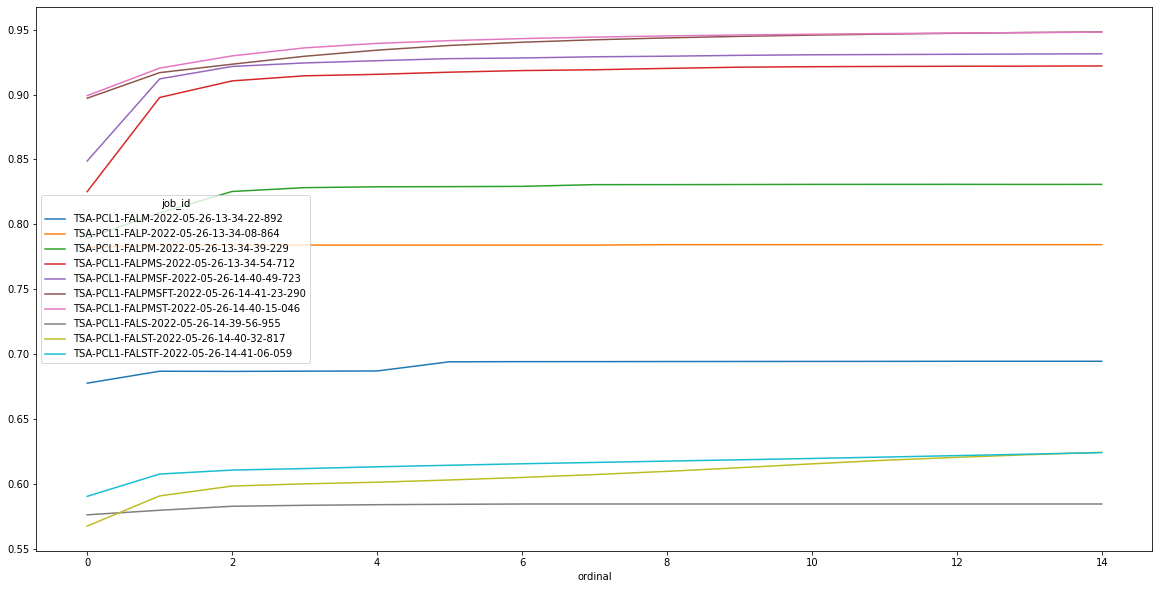

In [3]:
from matplotlib import pyplot as plt

job_ids = ['TSA-PCL1-FALPMS-2022-05-26-13-34-54-712',
 'TSA-PCL1-FALPM-2022-05-26-13-34-39-229',
 'TSA-PCL1-FALM-2022-05-26-13-34-22-892',
 'TSA-PCL1-FALP-2022-05-26-13-34-08-864',
 'TSA-PCL1-FALPMSFT-2022-05-26-14-41-23-290',
 'TSA-PCL1-FALSTF-2022-05-26-14-41-06-059',
 'TSA-PCL1-FALPMSF-2022-05-26-14-40-49-723',
 'TSA-PCL1-FALST-2022-05-26-14-40-32-817',
 'TSA-PCL1-FALPMST-2022-05-26-14-40-15-046',
 'TSA-PCL1-FALS-2022-05-26-14-39-56-955',
]

def parse_index(*prefixes):
    def _parse_index(df):
        for prefix in prefixes:
            reg = f'-{prefix}([^-]+)-'
            vals = df.index.str.extract(reg)
            df[prefix] = list(vals[0])
        return df
    return _parse_index
    
sl = SagemakerLogs(job_ids).load_from_s3()
_, ax = plt.subplots(1,1,figsize=(20,10))
sl.get_metric_by_job('roc_auc_score_test').plot(ax=ax)

sl.get_last_values().sort_values('roc_auc_score_test',ascending=False).feed(parse_index('FAL')).set_index('FAL')

So, the main portion of quality comes from comparison of `P`, `M` and `S` features. Probably errors distort slovnet harder that thought, including affecting its morphology analyzer (`pymorphy` analyzes word-by-word, while `slovnet` uses the whole sentence)

High-enough quality of pymorphy alone can be probably explained by simple memorizing of which verb (transitive/non-transitive etc) is in finite/infinite form more often

## Context length (PCL) and Feature Allow List (FAL)

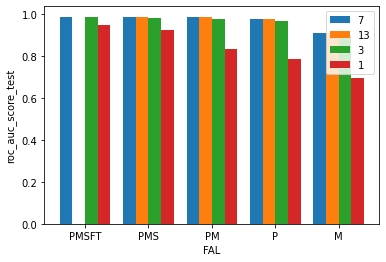

In [4]:
job_ids = [
# 'TSA-PCL13-FALPMSTF-2022-05-26-15-16-28-228',
 'TSA-PCL13-FALPMS-2022-05-26-15-16-13-114',
 'TSA-PCL13-FALPM-2022-05-26-15-15-58-239',
 'TSA-PCL13-FALP-2022-05-26-15-15-42-061',
 'TSA-PCL13-FALM-2022-05-26-15-15-25-508',
    
 'TSA-PCL7-FALPMSTF-2022-05-26-15-15-08-672',
 'TSA-PCL7-FALPMS-2022-05-26-15-14-50-173',
 'TSA-PCL7-FALPM-2022-05-26-15-14-35-208',
 'TSA-PCL7-FALP-2022-05-26-15-14-19-925',
 'TSA-PCL7-FALM-2022-05-26-15-14-05-039',
 'TSA-PCL3-FALPMSTF-2022-05-26-15-13-49-237',
 'TSA-PCL3-FALPMS-2022-05-26-15-13-31-230',
 'TSA-PCL3-FALPM-2022-05-26-15-13-11-681',
 'TSA-PCL3-FALP-2022-05-26-15-12-56-974',
 'TSA-PCL3-FALM-2022-05-26-15-12-42-479',
          
 'TSA-PCL1-FALM-2022-05-26-13-34-22-892',
 'TSA-PCL1-FALP-2022-05-26-13-34-08-864',
 'TSA-PCL1-FALPMS-2022-05-26-13-34-54-712',
 'TSA-PCL1-FALPM-2022-05-26-13-34-39-229',
 'TSA-PCL1-FALPMSFT-2022-05-26-14-41-23-290',
 ]


sl = SagemakerLogs(job_ids).load_from_s3()
#sl.get_metric_by_job('roc_auc_score_test').plot()

from tg.common.analysis import grbar_plot

cdf =  sl.get_last_values().sort_values('roc_auc_score_test',ascending=False).feed(parse_index('FAL','PCL'))
cdf.FAL = cdf.FAL.replace(dict(PMSTF='PMSFT'))
grbar_plot(cdf, value_column='roc_auc_score_test', group_column='FAL', color_column='PCL').legend()

So, the original idea also works with this task: the quality can be significantly increased by taking the context into account even without "cheat" with slovnet. In general, at least for this task, pymorphy is totally fine alone, which may be important as it's much faster than slovnet

In [5]:
cdf.sort_values(['FAL','PCL'])

metric,iteration,loss,roc_auc_score_display,roc_auc_score_test,FAL,PCL
job_id,,,,,,
TSA-PCL1-FALM-2022-05-26-13-34-22-892,14.0,0.220417,0.693429,0.694381,M,1
TSA-PCL13-FALM-2022-05-26-15-15-25-508,14.0,0.121476,0.910665,0.909427,M,13
TSA-PCL3-FALM-2022-05-26-15-12-42-479,14.0,0.132344,0.893863,0.895162,M,3
TSA-PCL7-FALM-2022-05-26-15-14-05-039,14.0,0.122269,0.908618,0.908714,M,7
TSA-PCL1-FALP-2022-05-26-13-34-08-864,14.0,0.189598,0.784168,0.784307,P,1
TSA-PCL13-FALP-2022-05-26-15-15-42-061,14.0,0.054088,0.975693,0.976055,P,13
TSA-PCL3-FALP-2022-05-26-15-12-56-974,14.0,0.069553,0.964872,0.966077,P,3
TSA-PCL7-FALP-2022-05-26-15-14-19-925,14.0,0.056171,0.973992,0.974899,P,7
TSA-PCL1-FALPM-2022-05-26-13-34-39-229,14.0,0.168207,0.829208,0.830777,PM,1


# LSTM

There is also an LSTM implementation. In this case, `m` features for `n` surrounding words and `k` batches are placed into 3-dim `n*m*k` tensor, which dimentionality is reduced by LSTM. Initial run has shown that LSTM was not productive.

Why: because there is one parameter which orders surrounding by proximity to the word in question. I wasn't sure which order (direct or reverse) to use.

metric,iteration,loss,roc_auc_score_display,roc_auc_score_test
job_id,,,,
TSA-EC100-PCL10-FALP-PCRTrue-PNMLSTM-2022-05-27-13-01-20-338,99.0,0.035871,0.982696,0.981734
TSA-EC100-PCL10-FALP-PCRFalse-PNMLSTM-2022-05-27-13-01-03-520,99.0,0.029557,0.983074,0.978325


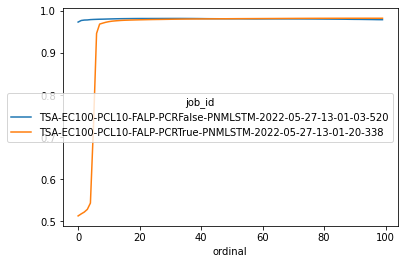

In [9]:
job_ids = ['TSA-EC100-PCL10-FALP-PCRTrue-PNMLSTM-2022-05-27-13-01-20-338',
 'TSA-EC100-PCL10-FALP-PCRFalse-PNMLSTM-2022-05-27-13-01-03-520'
]

sl = SagemakerLogs(job_ids).load_from_s3()
sl.get_metric_by_job('roc_auc_score_test').plot()

sl.get_last_values().sort_values('roc_auc_score_test',ascending=False)

So, _eventually_ both networks will converge to the almost-same result (the PCRFalse is overtrained). But the correct order seems to be `PCRFalse`, so, one should not reverse the order.

In general, this task (`FALP+PCL10`) can be used as an example of the simple real-world task to test other ways of dimentionality reduction.